# Simulating Spectra

Through DESI's specsim we will simulate mock spectra with FOBOS parameters

First we have to double check that our environment is setup. 

In [1]:
import os
def check_env():
    for env in ('DESIMODEL',):
        if env in os.environ:
            print('{} environment set to {}'.format(env, os.getenv(env)))
        else:
            print('Required environment variable {} not set!'.format(env))
check_env()

DESIMODEL environment set to /Users/RichardP/desi/code/desimodel


# Introduction

The first step we did was to check that the code to generate smoothed objects and their Mini-IFUs worked. Now we will use those magnitudes calculated to renormalize specsim spectra. 

In [2]:
cd /Users/RichardP/Research/FOBOS/py_FOBOS/

/Users/RichardP/research/fobos/py_FOBOS


In [3]:
import numpy as np
from astropy.io import fits
from astropy import wcs
import matplotlib.pyplot as plt
import scipy.ndimage.filters as ndimage
#This is the specific code
import fobos_sim

In [4]:
gen = fobos_sim.fobos_sim('/Users/RichardP/Research/FOBOS/Samples/acs_I_030mas_088_sci.fits')
gen.catalog_info('/Users/RichardP/Research/FOBOS/Samples/photoz_vers2.0_010312_UltraVISTA2016.fits')

First, we are going to look for a specific object with IMAG between 23 - 24 and save them into a list for specsim later. These objects will be the magnitude objects we use to renormalize.

In [5]:
gen.target_indexes = []
def sample_index():
    counter = 0
    for i in range(0, len(gen.objects_index)):
        if counter <= 70:
            if gen.objects_Imag[i] > 23 and gen.objects_Imag[i] < 24:
                print(str(gen.objects_id[i]) + "_" + str(i) + ": " + str(gen.objects_Imag[i]))
                gen.target_indexes.append(i)
                counter += 1
sample_index()


1423982_2: 23.93
1424243_8: 23.836
1424298_9: 23.664
1424367_11: 23.985
1424429_13: 23.819
1424449_14: 23.402
1424505_16: 23.276
1424533_17: 23.116
1424534_18: 23.16
1424536_19: 23.73
1424582_24: 23.512
1424639_32: 23.282
1424647_33: 23.187
1424658_39: 23.325
1424737_43: 23.032
1424742_44: 23.239
1424803_45: 23.858
1424883_51: 23.471
1425000_57: 23.785
1425122_62: 23.508
1425139_63: 23.978
1425143_65: 23.967
1425245_68: 23.299
1425537_97: 23.696
1425621_99: 23.808
1425747_109: 23.566
1425749_110: 23.401
1425757_113: 23.864
1425759_114: 23.934
1425760_115: 23.845
1425763_117: 23.903
1425765_118: 23.103
1425781_121: 23.708
1425867_123: 23.582
1425883_126: 23.039
1425886_127: 23.672
1425930_135: 23.672
1425969_136: 23.722
1426036_138: 23.648
1426094_142: 23.867
1426147_147: 23.681
1426167_148: 23.892
1426175_150: 23.254
1426434_155: 23.668
1426495_157: 23.654
1426496_158: 23.347
1426802_171: 23.801
1426817_172: 23.662
1426940_179: 23.697
1426963_180: 23.277
1427096_189: 23.913
1427117_194

## Smoothing

We will start by doing our basic Mini-IFU overplotting and then smoothing with FWHM = .7. We guess that the seeing will be around .7 and can change that value to more extreme seeing conditions. This is needed because of the inherent seeing caused by the atmosphere. 

In [6]:
gen.overplotting()

In [7]:
FWHM = .7
gen.smooth(FWHM)
gen.smoothing(FWHM)

Now we will run a simple script to convert the smoothed fluxes to magnitudes and compile into lists according to their Mini-IFU's. This will organize us for the next step when we want to renormalize the spectra

In [8]:
gen.mag_organization()

/Users/RichardP/research/fobos/py_FOBOS/fobos_sim.py:351: RuntimeWarning: invalid value encountered in log10
  ABMAG =  ((-2.5 * np.log10(FluxVals[i])) +23.9)


In [9]:
print(len(gen.Mag0))
print(len(gen.Mag1))
print(len(gen.Mag2))
print(len(gen.Mag3))
print(len(gen.Mag4))
print(len(gen.Mag5))
print(len(gen.Mag6))

71
71
71
71
71
71
71


Sanity check we have 71 magnitudes for each Mini-IFU totaling to 497 total "fibers. We will now begin to incorporate specsim.

## Setting Up Specsim

We have our magnitudes for the Mini-IFUs and now we just need our mock spectra.

Here is link for the doc instructing on setting up specsim. 

https://www.evernote.com/l/Ar1Rsj1ZwFpM77nrwimGqa3bSIDhqMb039M

Now desi.yaml should be set. The import parameters for desi.yaml is the primary diameter and obscuration diameter as it sets up the instrument. All the other information is "technically" pertinent to FOBOS such as atmosphere and source. However, the source input parameters such as z_in and z_out we can and will edit in this notebook.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import numpy as np

We will now import the simulator. If you have not done so already download specsim in your environment <br>
<b>$pip install specsim<b>

In [12]:
import specsim.simulator

We want to generate 71 spectra each with 7 fibers. This is to represent 7 Mini-IFUs multiplied by 71 total objects. We will assume that the redshift of these objects are random between redshift 2 and redshift 3 so we can differentiate between spectra. The input parameters for this method is gen.gen_spectra(yaml path, number of fibers, number of  spectra, redshift input, redshift output, abmag output

In [13]:
gen.gen_spectra('/users/richardp/research/fobos/desi/specsim/specsim/data/config/fobos.yaml', 7, 71, 0, 2.5, 23)

/Users/RichardP/anaconda3/envs/plue/lib/python3.5/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


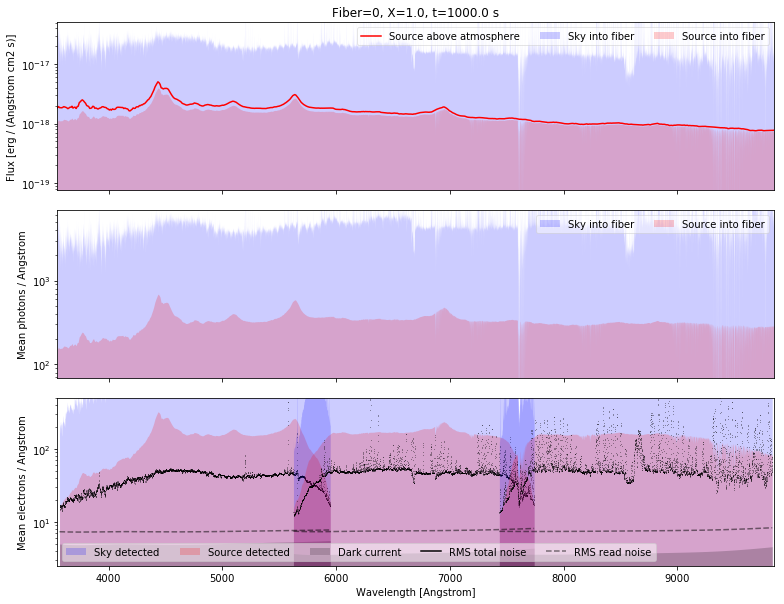

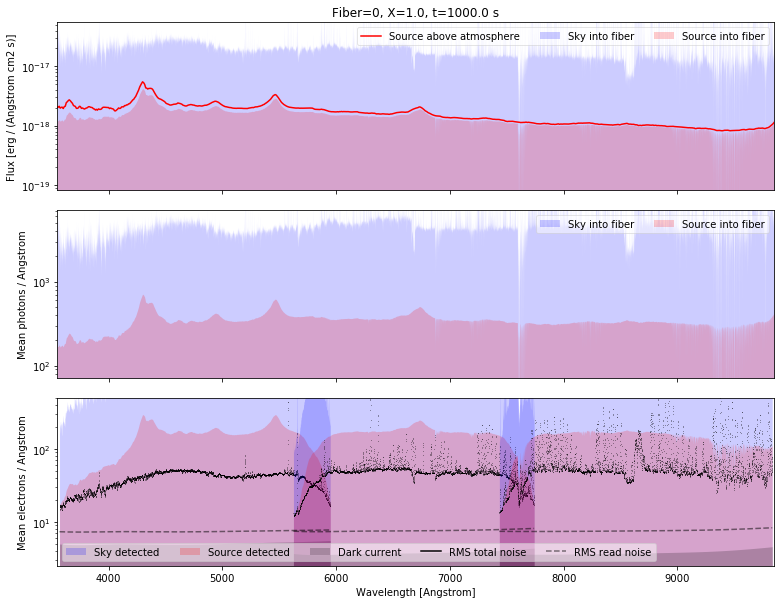

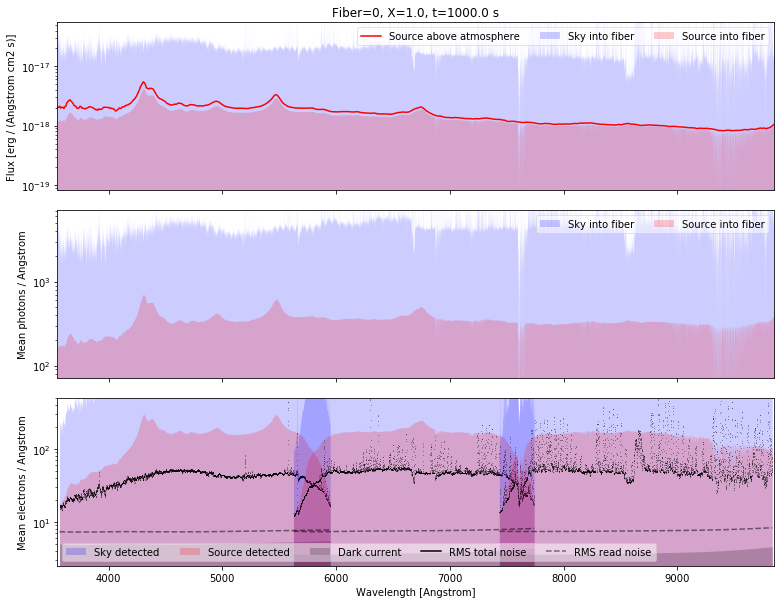

In [14]:
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()

We have set up a dictionary called fobos with 71 different spectra that have random redshift. We have normalized about abmag 23, but we will renormalize according to the magnitude values calculated earlier. 

Now we want to renormalize the values. gen_spec has a method to do this renormalization for us. 

In [17]:
def mag_normalization(Mini_IFU_list, original_mag, IFU_number):
    for i in range(0,71):
        for j in range(0,63001):
            gen.renormalization(Mini_IFU_list[i], original_mag, float(gen.fobos[str(i)].simulated["source_flux"][j][IFU_number]))
            gen.fobos[str(i)].simulated["source_flux"][j][IFU_number] = gen.flux1val
mag_normalization(gen.Mag0, 23, 0)
mag_normalization(gen.Mag1, 23, 1)
mag_normalization(gen.Mag2, 23, 2)
mag_normalization(gen.Mag3, 23, 3)
mag_normalization(gen.Mag4, 23, 4)
mag_normalization(gen.Mag5, 23, 5)
mag_normalization(gen.Mag6, 23, 6)

We have now renormalized the spectra for each fiber according to the Mini-IFU counter part. To do this we indexed through every fobos wavelength and renormalized the spectra according to the Mini-IFU counterpart. 

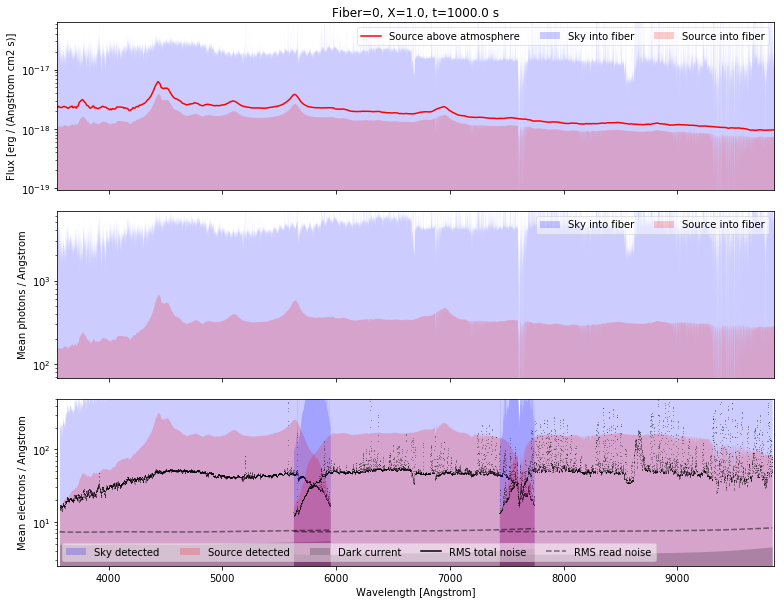

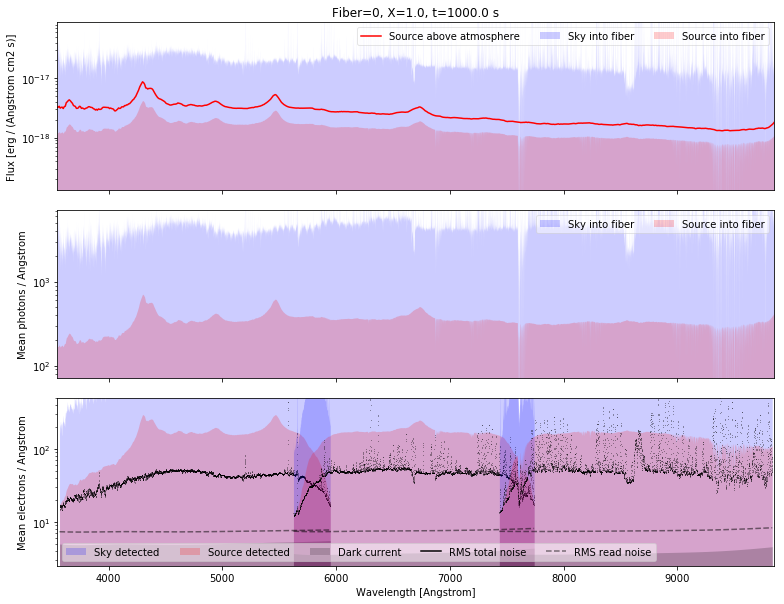

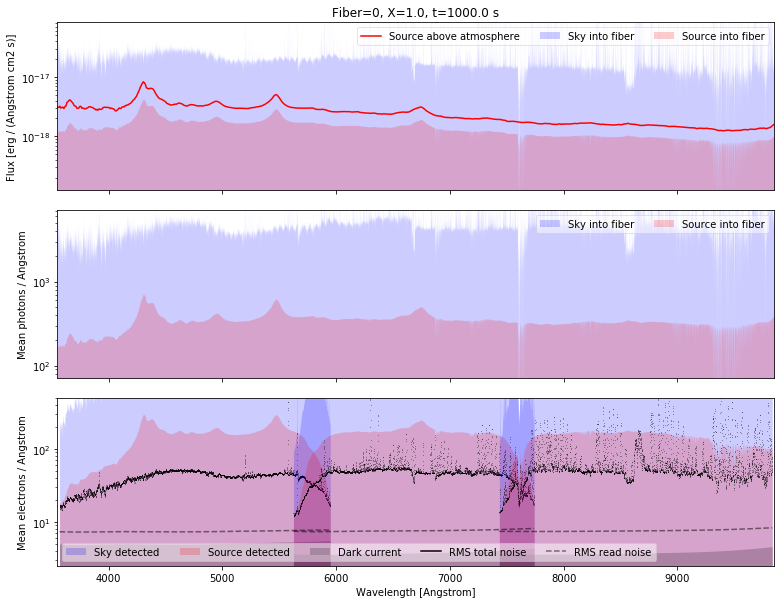

In [18]:
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()

In [20]:
print(gen.fobos['1'].simulated["source_flux"][0])

[  2.28938148e-18   1.65575445e-19   2.39865158e-19   5.94589246e-19
   9.31515921e-19   1.29805325e-18   4.03118606e-19]


# Different Seeing

We will now rerun the code with different FWHM to see the impact.

/Users/RichardP/research/fobos/py_FOBOS/fobos_sim.py:351: RuntimeWarning: invalid value encountered in log10
  ABMAG =  ((-2.5 * np.log10(FluxVals[i])) +23.9)


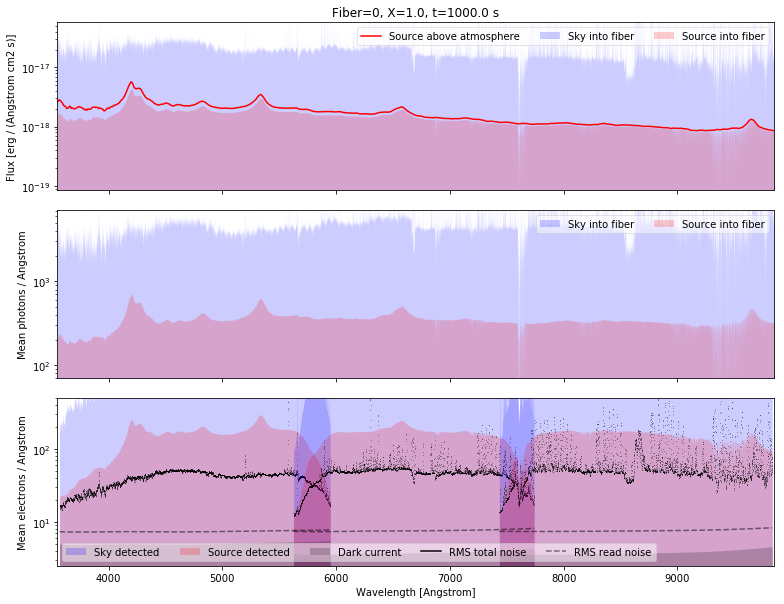

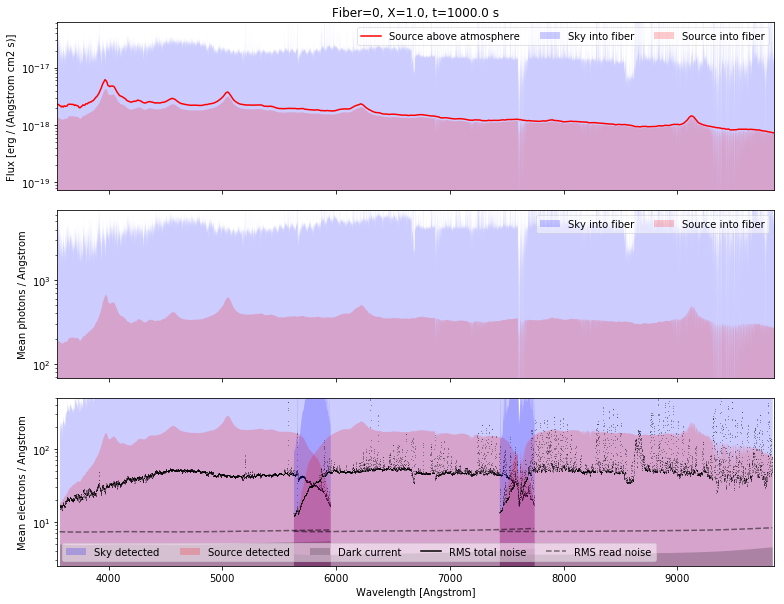

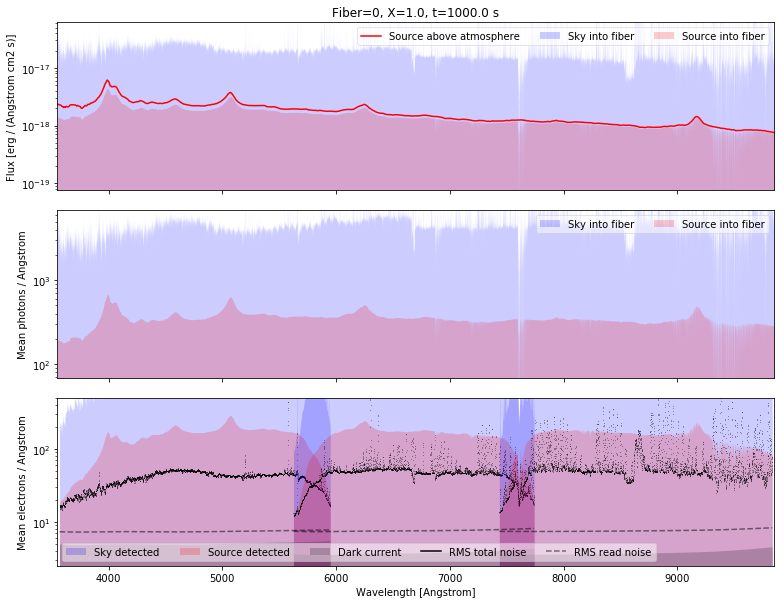

In [22]:
FWHM = 1.0
gen.smooth(FWHM)
gen.smoothing(FWHM)
gen.mag_organization()
gen.gen_spectra('/users/richardp/research/fobos/desi/specsim/specsim/data/config/fobos.yaml', 7, 71, 0, 2.5, 23)
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()


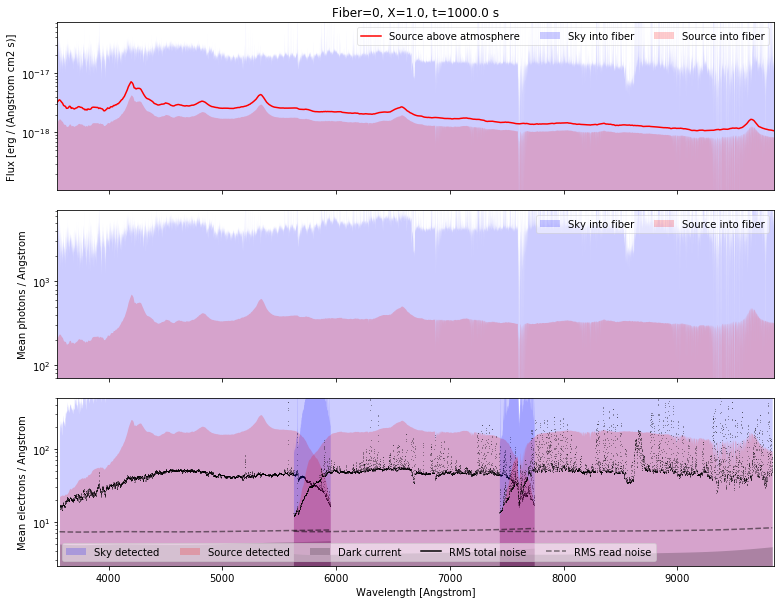

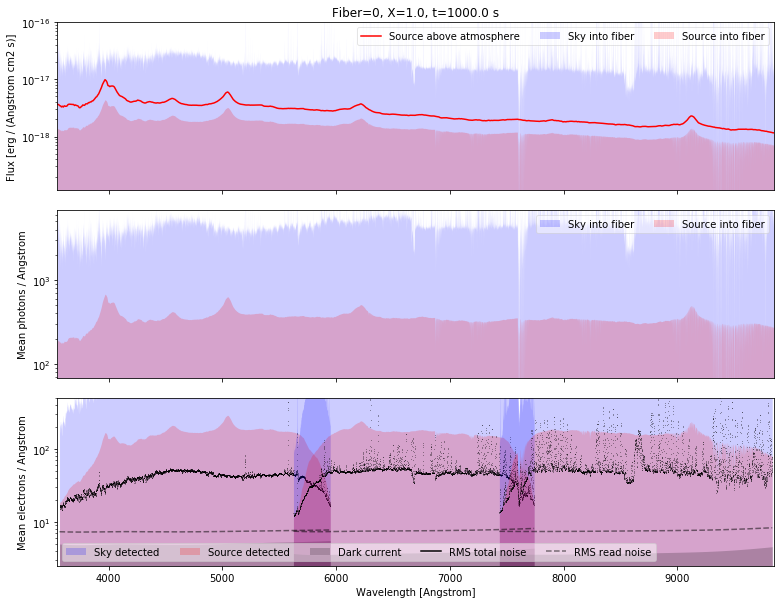

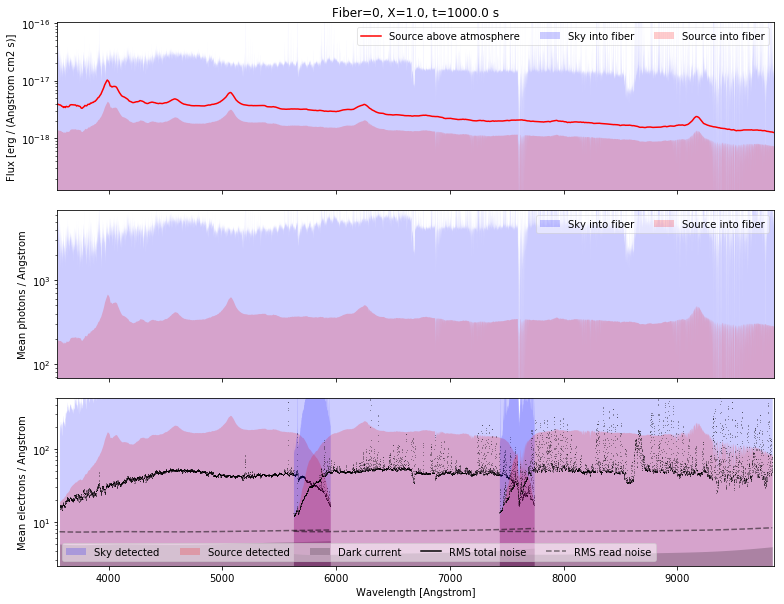

In [23]:
mag_normalization(gen.Mag0, 23, 0)
mag_normalization(gen.Mag1, 23, 1)
mag_normalization(gen.Mag2, 23, 2)
mag_normalization(gen.Mag3, 23, 3)
mag_normalization(gen.Mag4, 23, 4)
mag_normalization(gen.Mag5, 23, 5)
mag_normalization(gen.Mag6, 23, 6)
gen.fobos['1'].plot()
gen.fobos['20'].plot()
gen.fobos['32'].plot()